In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
random.seed(666)
torch.manual_seed(666)

# Load Data

In [3]:
from pathlib import Path
from npz_loader import build_episodes_from_sequences
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths, build_episodes_from_sequences

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
    # Path(r"dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4"),
    # Path(r"dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4"),
    # Path(r"dataset\PongNoFrameskip-v4\PongNoFrameskip-v4"),
    # Path(r"dataset\QbertNoFrameskip-v4\QbertNoFrameskip-v4"),
    # Path(r"dataset\SeaquestNoFrameskip-v4\SeaquestNoFrameskip-v4"),
    # Path(r"dataset\SpaceInvadersNoFrameskip-v4\SpaceInvadersNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")
episodes = build_episodes_from_sequences(sequences_by_game)

In [4]:
dataset_fraction = .1 # Set this from 0 to 1 to sample a fraction of the dataset
sample_size = max(1, int(len(episodes) * dataset_fraction))
sampled_episodes = random.sample(episodes, sample_size)
print(f"Sampled {len(sampled_episodes)} episodes ({len(sampled_episodes)/len(episodes)*100:.1f}% of {len(episodes)} total)")

Sampled 40 episodes (10.0% of 400 total)


In [5]:
from episode_dataset import make_train_val_dataloaders

train_loader, val_loader, train_dataset, val_dataset, bins = make_train_val_dataloaders(
    sampled_episodes,
    train_frac=0.9,
    timestep_window_size=4,
    image_size=(84, 84),
    batch_size=32,
)

=== Dataloader Sanity Check: TRAIN ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 2 -> {'BeamRiderNoFrameskip-v4': 1410, 'BreakoutNoFrameskip-v4': 190}
Actions: min=0, max=8, unique=9
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=15.000
Reward bins: unique=[1 2]
RTG bins: min=0, max=15
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'BeamRiderNoFrameskip-v4': 1410, 'BreakoutNoFrameskip-v4': 190}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 15.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins_min': 0, 'rtg_bins_max': 15}


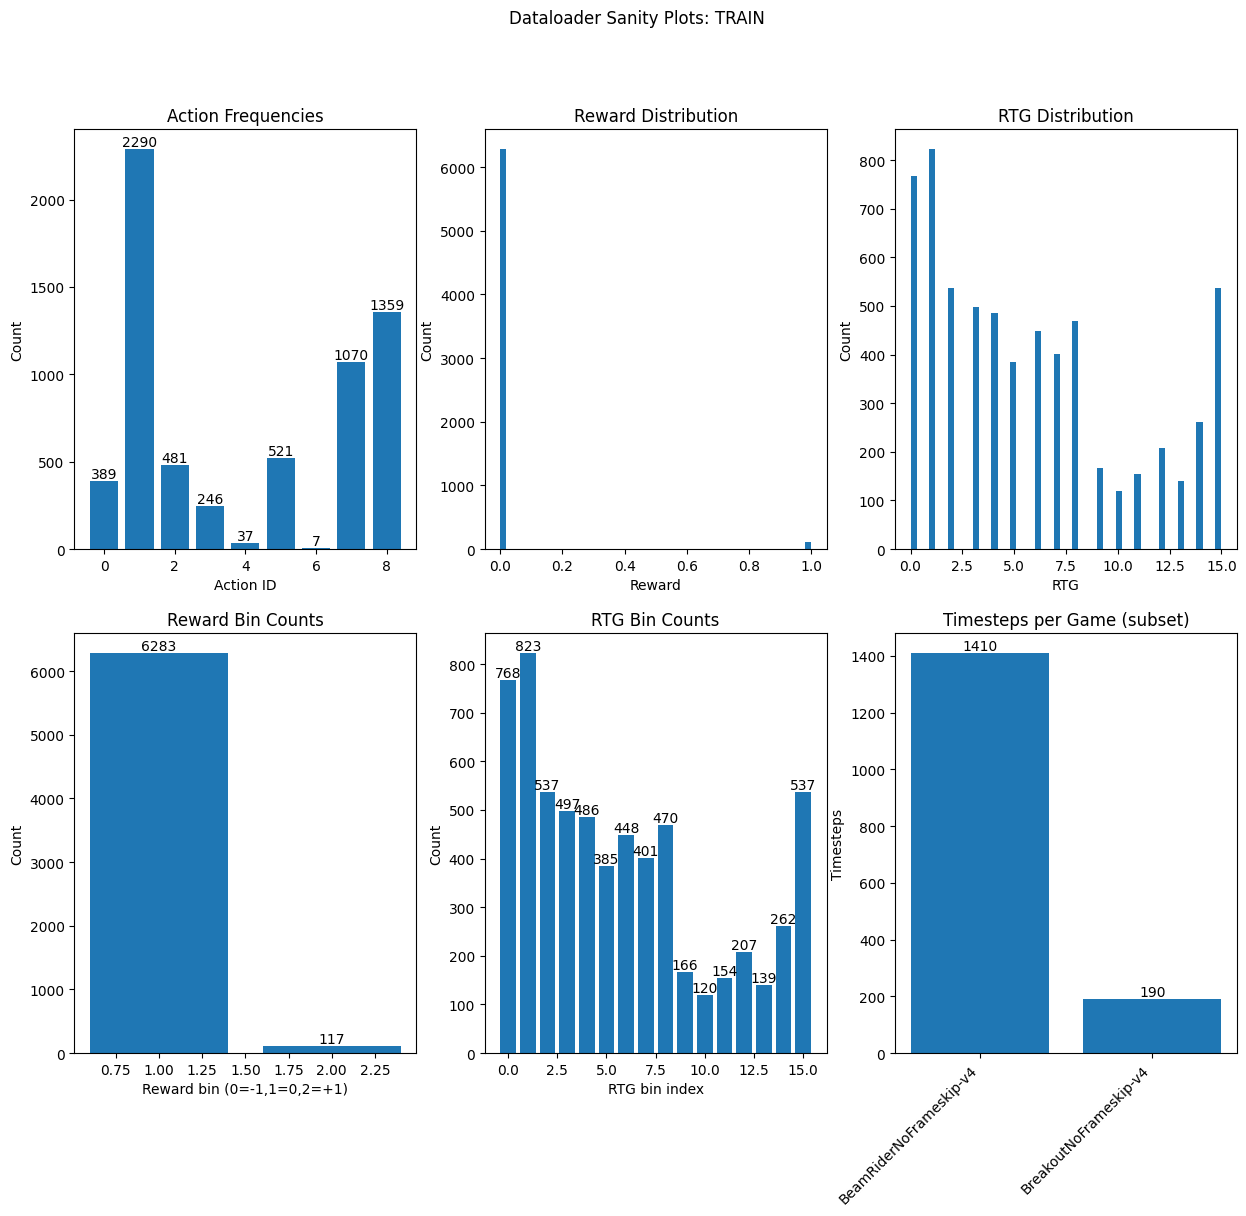

=== Dataloader Sanity Check: VAL ===
Used batches: 48
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6076
Games in subset: 2 -> {'BreakoutNoFrameskip-v4': 1058, 'BeamRiderNoFrameskip-v4': 461}
Actions: min=0, max=8, unique=8
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=25.000
Reward bins: unique=[1 2]
RTG bins: min=0, max=25
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 48, 'n_timesteps': 6076, 'game_counts': {'BreakoutNoFrameskip-v4': 1058, 'BeamRiderNoFrameskip-v4': 461}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 8, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 25.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins_min': 0, 'rtg_bins_max': 25}


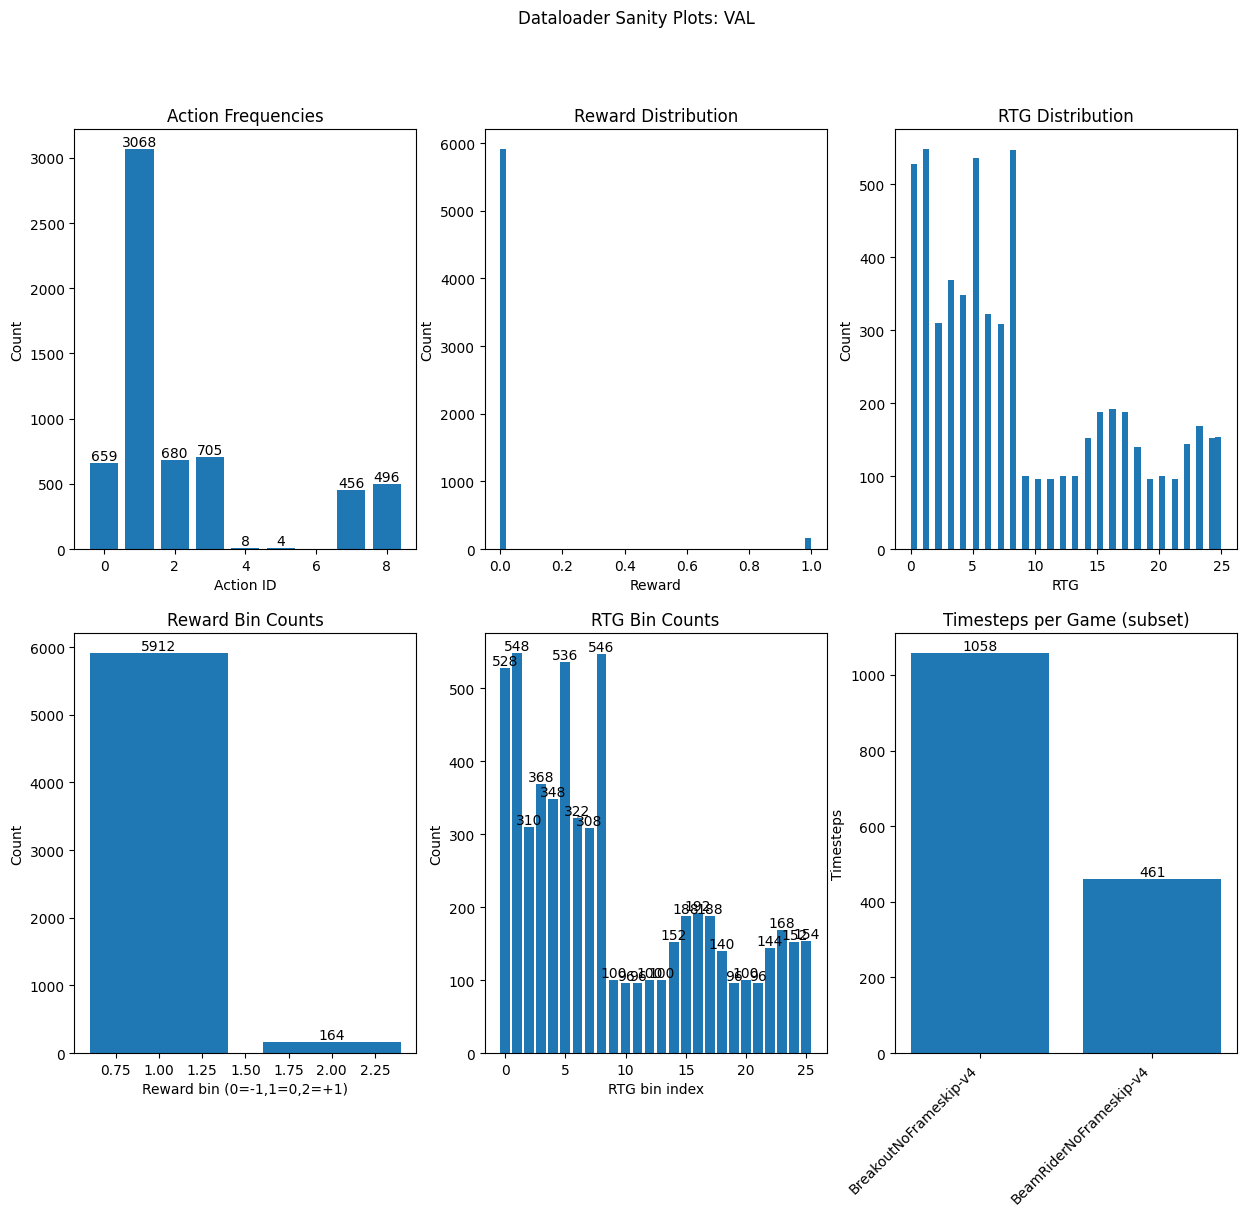

In [6]:
from dataloader_stats import inspect_dataloader

inspect_dataloader(train_loader, "TRAIN")
inspect_dataloader(val_loader, "VAL")

# Train

In [7]:
from mgdt_model_trainer import Encoder, train_mgdt

model, train_stats, val_stats = train_mgdt(
    bins=bins,
    dataloader_train=train_loader,
    dataloader_val=val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=5,
)

Epoch 5/5: 100%|██████████| 542/542 [00:51<00:00, 10.59it/s]


# Look at Results

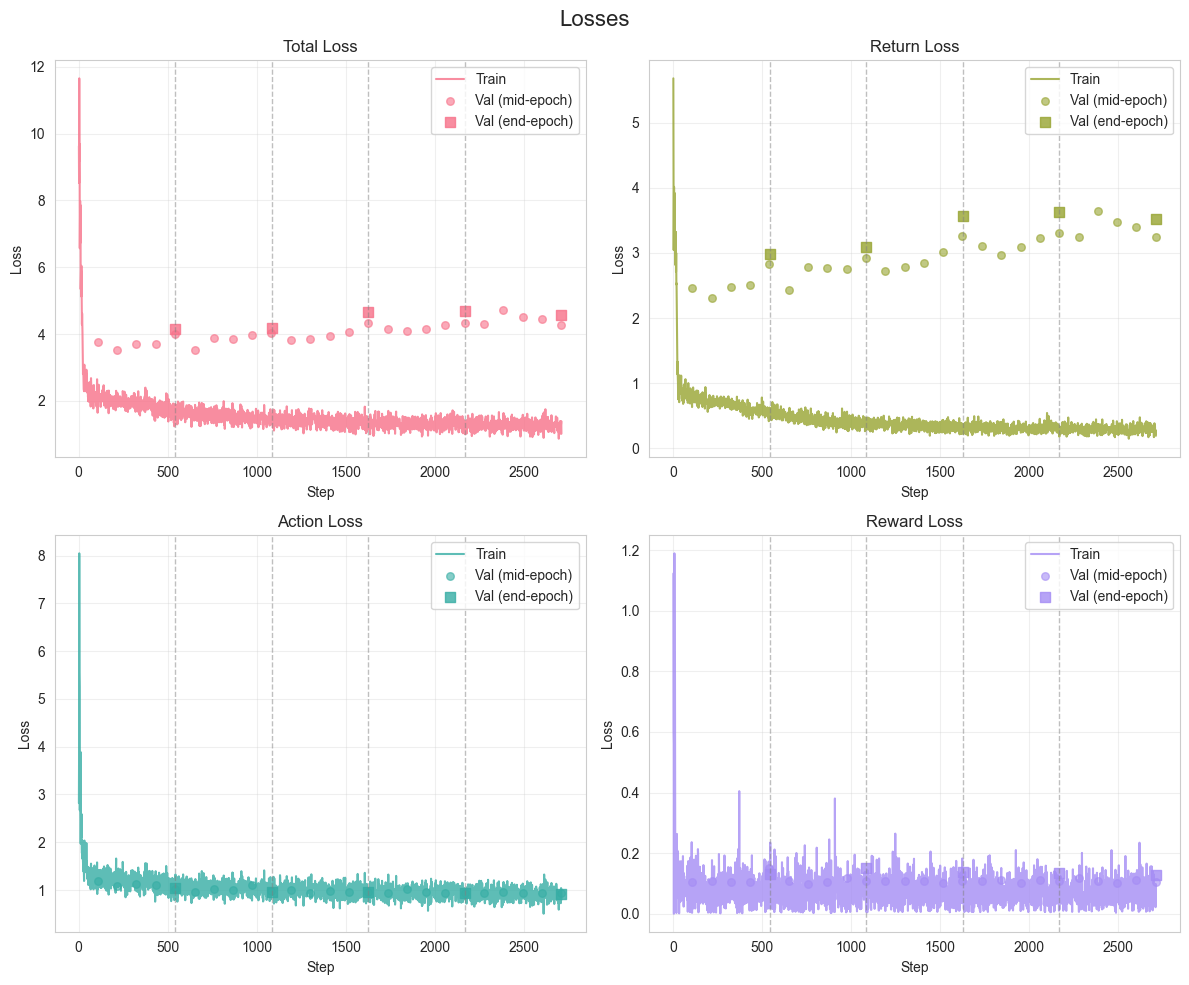

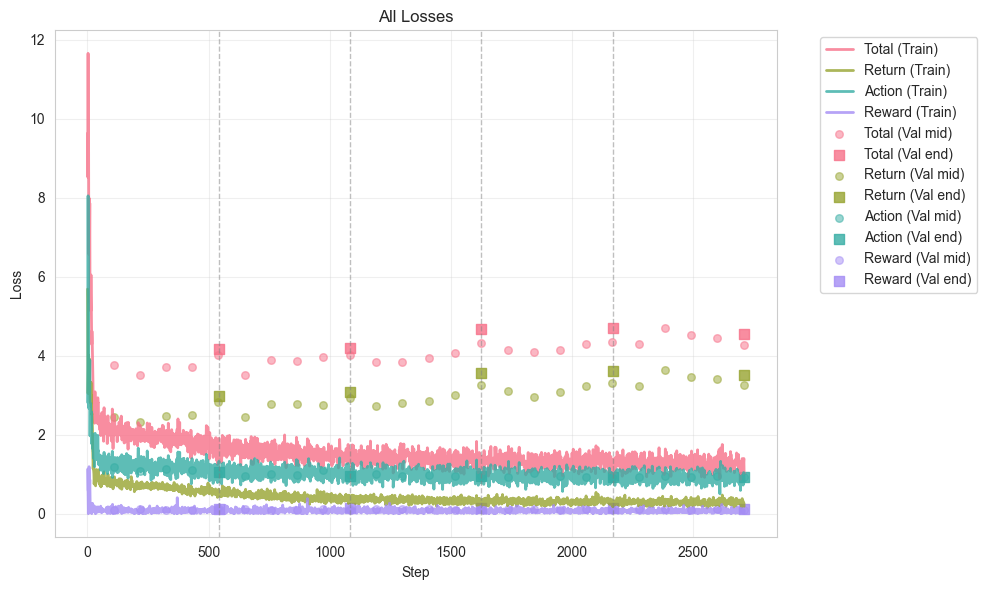

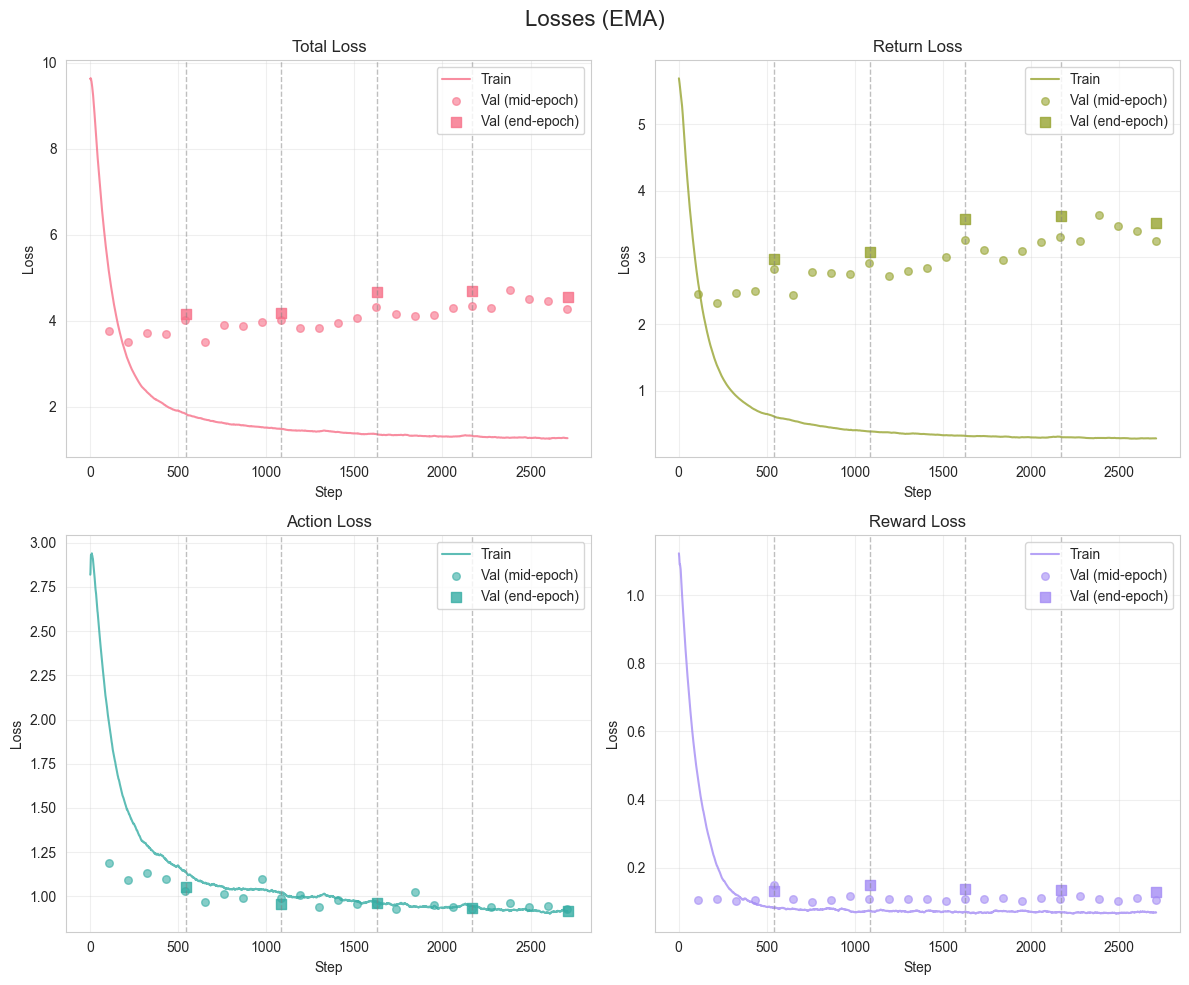

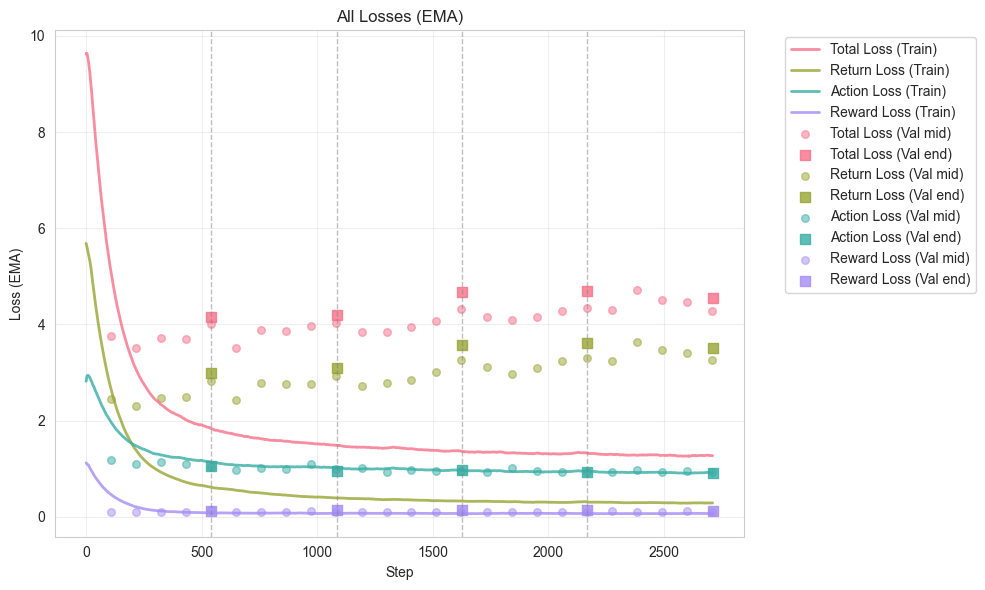

In [8]:
from mgdt_model_stats import plot_losses
plot_losses(train_stats, val_stats)

In [9]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

Total parameters: 20M


In [10]:
import pickle
from pathlib import Path

# Save model to file
model_path = Path("output/model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(model, f)
print(f"Model saved to {model_path}")

Model saved to output\model.pkl
